In [1]:
# Clone the repo to access Data/, code/, etc.
!git clone https://github.com/mr-kelsey/su25-aai511-group6.git
%cd su25-aai511-group6
import os
print("Working directory:", os.getcwd())



Cloning into 'su25-aai511-group6'...
remote: Enumerating objects: 3231, done.
remote: Counting objects: 100% (3231/3231), done.
remote: Compressing objects: 100% (3157/3157), done.
remote: Total 3231 (delta 90), reused 3190 (delta 66), pack-reused 0 (from 0)
Receiving objects: 100% (3231/3231), 26.22 MiB | 3.62 MiB/s, done.
Resolving deltas: 100% (90/90), done.
/content/su25-aai511-group6
Working directory: /content/su25-aai511-group6


In [2]:
!ls /content


sample_data  su25-aai511-group6


In [3]:
from pathlib import Path

DATA_PATH = Path("Data")
AUG_PATH = DATA_PATH / "Augmented"
midi_paths = list(AUG_PATH.glob("**/*.mid"))
print(f"✅ Found {len(midi_paths)} MIDI files")


✅ Found 400 MIDI files


In [4]:
!pip install miditok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.0/159.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 49.5 MB/s eta 0:00:00


In [5]:
!pip install miditok miditoolkit torchmetrics matplotlib tqdm ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [6]:
"""Imports"""
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from miditok import REMI, TokenizerConfig
from miditok.pytorch_data import DatasetMIDI, DataCollator
from miditok.utils import split_files_for_training
from pathlib import Path
from random import shuffle, seed as random_seed
from torch.utils.data import DataLoader
from torchmetrics import Accuracy, Precision, Recall, F1Score, ConfusionMatrix
from torchmetrics.classification import MulticlassConfusionMatrix

In [7]:
"""Set seeds and device"""
random_seed(73)
np.random.seed(73)
torch.manual_seed(73)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(73)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Prepare Data for LSTM architecture

In [8]:
"""Train new tokenizer based on all augmented data"""
DATA_PATH = Path(Path.cwd().parent, "Data")
midi_paths = list(Path(DATA_PATH, "Augmented").glob(f"**/*.mid"))

config = TokenizerConfig(use_chords=True, use_rests=True, use_tempos=True, use_programs=True, one_token_stream_for_programs=False)
tokenizer = REMI(config)
tokenizer.train(vocab_size=500, files_paths=midi_paths)

tokenizer.is_trained
# NOTE: The vocab_size is a hyperparameter we could play with for optimization

print(tokenizer.is_trained)


True


In [9]:
from miditoolkit import MidiFile

# Filter midi_paths to keep only files that contain notes
def file_has_notes(path):
    try:

        midi = MidiFile(str(path))

        return any(len(track.notes) > 0 for track in midi.instruments)
    except:
        return False

midi_paths = [p for p in midi_paths if file_has_notes(p)]
print(f"✅ {len(midi_paths)} files with notes retained")




✅ 0 files with notes retained


In [10]:
from pathlib import Path

# Recursively get all .mid files from the Augmented folder
midi_paths = list(Path("Data/Augmented").rglob("*.mid"))

print(f"🎵 Found {len(midi_paths)} .mid files")


🎵 Found 400 .mid files


In [11]:
for p in midi_paths[:5]:
    print(p)


Data/Augmented/Beethoven/0012_26#p-6.mid
Data/Augmented/Beethoven/0012_16#d96.mid
Data/Augmented/Beethoven/0012_4#v4.mid
Data/Augmented/Beethoven/0012_39#v-4.mid
Data/Augmented/Beethoven/0012_32#v-4.mid


In [12]:
from miditoolkit import MidiFile

def file_has_notes(path):
    try:
        midi = MidiFile(str(path))
        # Fallback to checking notes even if .instruments is empty
        if midi.instruments:
            return any(len(track.notes) > 0 for track in midi.instruments)
        else:
            return len(midi.notes) > 0  # Fallback for type-0 files
    except Exception as e:
        print(f"❌ Error in {path.name}: {e}")
        return False


In [13]:
filtered_paths = [p for p in midi_paths if file_has_notes(p)]
print(f"✅ {len(filtered_paths)} files with notes retained")



✅ 400 files with notes retained


In [14]:
from pathlib import Path

# Always resolve to absolute paths to avoid mismatch
midi_paths = list(Path("Data/Augmented").resolve().rglob("*.mid"))

In [15]:
"""Split into train/valid/test datasets using roughly 15% of the data for each of valid and test"""
total_num_files = len(midi_paths)
num_files_valid = round(total_num_files * 0.15)
num_files_test = round(total_num_files * 0.15)
shuffle(midi_paths)
midi_paths_valid = midi_paths[:num_files_valid]
midi_paths_test = midi_paths[num_files_valid:num_files_valid + num_files_test]
midi_paths_train = midi_paths[num_files_valid + num_files_test:]

for files_paths, subset_name in (
    (midi_paths_train, "Train"), (midi_paths_valid, "Validate"), (midi_paths_test, "Test")
):
    subset_chunks_dir = Path(DATA_PATH, "LSTM", subset_name)
    split_files_for_training(
        files_paths=files_paths,
        tokenizer=tokenizer,
        save_dir=subset_chunks_dir,
        max_seq_len=1024,
        num_overlap_bars=2,
    )

Splitting music files (/content/Data/LSTM/Train): 100%|██████████| 280/280 [00:00<00:00, 1077.33it/s]
Splitting music files (/content/Data/LSTM/Validate): 100%|██████████| 60/60 [00:00<00:00, 696.40it/s]
Splitting music files (/content/Data/LSTM/Test): 100%|██████████| 60/60 [00:00<00:00, 700.81it/s]


In [22]:
"""Create torch compatable data loaders using the datasets created above"""
#TODO See if we can make padding happen in the dataloader itself instead of needing to pad the data generated by the data loader
class Capture:
	def __init__(self):
		self.score = None
		self.tok_sequence = None

	def lable_composer(self, score, tok_sequence, file_path):
		self.score = score
		self.tok_sequence = tok_sequence
		composer = file_path.parts[-2:-1]
		if "Bach" in composer:
			return [1,0,0,0]
		elif "Beethoven" in composer:
			return [0,1,0,0]
		elif "Chopin" in composer:
			return [0,0,1,0]
		elif "Mozart" in composer:
			return [0,0,0,1]
		else:
			return [0,0,0,0]

capture = Capture()
collator = DataCollator(tokenizer.pad_token_id)
use_cuda = torch.cuda.is_available()

dataset_train = DatasetMIDI(
    files_paths=list(Path(DATA_PATH, "LSTM", "Train").glob("**/*.mid")),
    tokenizer=tokenizer,
    max_seq_len=1024,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
    func_to_get_labels=capture.lable_composer
)
dataloader_train = DataLoader(dataset_train, batch_size=16, collate_fn=collator, shuffle=True, pin_memory=use_cuda)

dataset_valid = DatasetMIDI(
    files_paths=list(Path(DATA_PATH, "LSTM", "Validate").glob("**/*.mid")),
    tokenizer=tokenizer,
    max_seq_len=1024,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
	func_to_get_labels=capture.lable_composer
)
dataloader_valid = DataLoader(dataset_valid, batch_size=16, collate_fn=collator, shuffle=True, pin_memory=use_cuda) # increased batch size to 16 for faster training

dataset_test = DatasetMIDI(
    files_paths=list(Path(DATA_PATH, "LSTM", "Test").glob("**/*.mid")),
    tokenizer=tokenizer,
    max_seq_len=1024,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
	func_to_get_labels=capture.lable_composer
)
dataloader_test = DataLoader(dataset_test, batch_size=16, collate_fn=collator, pin_memory=use_cuda) #using pin memory to make execution faster in GPU(by speeding up datatrafer from cpu to gpu)

Build Model

In [23]:
# LSTM model definition for sequence prediction


class ComposerLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0):
        super(ComposerLSTM, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)

        self.fc1 = nn.Linear(hidden_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # x is a PackedSequence
        packed_output, (hn, cn) = self.lstm(x)

        # Use the last hidden state of the final layer
        # out = hn[-1]  # shape: (batch_size, hidden_size)
        out = hn[-1]

        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out



Train Model

In [24]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, training_loader, validation_loader, lr=1e-4):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    model.train()

    for batch in tqdm(training_loader, desc="Training"):
        input_seqs = batch["input_ids"]
        #lengths = torch.tensor([len(seq) for seq in input_seqs]).to(device)
        lengths = torch.tensor([len(seq) for seq in input_seqs], dtype=torch.int64)  # ensure int64 on CPU




        # Pad and pack
        padded_inputs = pad_sequence(input_seqs, batch_first=True, padding_value=tokenizer.pad_token_id).to(device)
        padded_inputs = padded_inputs.float().unsqueeze(-1)  # shape: (batch, seq_len, 1)
        packed_inputs = pack_padded_sequence(padded_inputs, lengths, batch_first=True, enforce_sorted=False)

        labels = batch["labels"].to(device).float()

        optimizer.zero_grad()
        outputs = model(packed_inputs)  # <-- model must accept packed inputs
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # Validation loop
    validation_losses = []
    model.eval()
    with torch.no_grad():
        for batch in validation_loader:
            v_input_seqs = batch["input_ids"]
            #v_lengths = torch.tensor([len(seq) for seq in v_input_seqs]).to(device)
            v_lengths = torch.tensor([len(seq) for seq in v_input_seqs], dtype=torch.int64)

            v_padded = pad_sequence(v_input_seqs, batch_first=True, padding_value=tokenizer.pad_token_id).to(device)

            v_padded = v_padded.float().unsqueeze(-1)
            v_packed = pack_padded_sequence(v_padded, v_lengths, batch_first=True, enforce_sorted=False)

            v_labels = batch["labels"].to(device).float()
            v_outputs = model(v_packed)
            v_loss = criterion(v_outputs, v_labels)
            validation_losses.append(v_loss.item())

    return train_losses, validation_losses





# Train LSTM model
# Initialize your model with correct input_size
model = ComposerLSTM(input_size=1, hidden_size=512, num_layers=1, num_classes=4).to(device) ## changing hidden size from 4096 to 512

epochs = 50
total_train_losses = []
total_validation_losses = []

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    train_loss, val_loss = train(model, dataloader_train, dataloader_valid)
    total_train_losses.append(sum(train_loss) / len(train_loss))
    total_validation_losses.append(sum(val_loss) / len(val_loss))

    print(f"Train Loss: {total_train_losses[-1]:.4f}, Val Loss: {total_validation_losses[-1]:.4f}")



Epoch 1/50


Training: 100%|██████████| 32/32 [00:06<00:00,  4.92it/s]


Train Loss: 0.2550, Val Loss: 0.2334

Epoch 2/50


Training: 100%|██████████| 32/32 [00:05<00:00,  6.28it/s]


Train Loss: 0.1988, Val Loss: 0.1843

Epoch 3/50


Training: 100%|██████████| 32/32 [00:05<00:00,  5.69it/s]


Train Loss: 0.1790, Val Loss: 0.1740

Epoch 4/50


Training: 100%|██████████| 32/32 [00:05<00:00,  5.62it/s]


Train Loss: 0.1760, Val Loss: 0.1738

Epoch 5/50


Training: 100%|██████████| 32/32 [00:05<00:00,  5.61it/s]


Train Loss: 0.1797, Val Loss: 0.1712

Epoch 6/50


Training: 100%|██████████| 32/32 [00:05<00:00,  6.22it/s]


Train Loss: 0.1775, Val Loss: 0.1763

Epoch 7/50


Training: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


Train Loss: 0.1764, Val Loss: 0.1723

Epoch 8/50


Training: 100%|██████████| 32/32 [00:05<00:00,  6.19it/s]


Train Loss: 0.1723, Val Loss: 0.1725

Epoch 9/50


Training: 100%|██████████| 32/32 [00:05<00:00,  5.92it/s]


Train Loss: 0.1782, Val Loss: 0.1732

Epoch 10/50


Training: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


Train Loss: 0.1732, Val Loss: 0.1716

Epoch 11/50


Training: 100%|██████████| 32/32 [00:05<00:00,  5.98it/s]


Train Loss: 0.1723, Val Loss: 0.1713

Epoch 12/50


Training: 100%|██████████| 32/32 [00:05<00:00,  5.99it/s]


Train Loss: 0.1751, Val Loss: 0.1767

Epoch 13/50


Training: 100%|██████████| 32/32 [00:05<00:00,  6.12it/s]


Train Loss: 0.1728, Val Loss: 0.1715

Epoch 14/50


Training: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


Train Loss: 0.1715, Val Loss: 0.1814

Epoch 15/50


Training: 100%|██████████| 32/32 [00:05<00:00,  6.06it/s]


Train Loss: 0.1722, Val Loss: 0.1695

Epoch 16/50


Training: 100%|██████████| 32/32 [00:05<00:00,  5.65it/s]


Train Loss: 0.1738, Val Loss: 0.1731

Epoch 17/50


Training: 100%|██████████| 32/32 [00:05<00:00,  6.21it/s]


Train Loss: 0.1704, Val Loss: 0.1710

Epoch 18/50


Training: 100%|██████████| 32/32 [00:05<00:00,  5.65it/s]


Train Loss: 0.1735, Val Loss: 0.1694

Epoch 19/50


Training: 100%|██████████| 32/32 [00:05<00:00,  5.93it/s]


Train Loss: 0.1684, Val Loss: 0.1710

Epoch 20/50


Training: 100%|██████████| 32/32 [00:05<00:00,  5.64it/s]


Train Loss: 0.1664, Val Loss: 0.1638

Epoch 21/50


Training: 100%|██████████| 32/32 [00:05<00:00,  6.25it/s]


Train Loss: 0.1655, Val Loss: 0.1668

Epoch 22/50


Training: 100%|██████████| 32/32 [00:05<00:00,  5.67it/s]


Train Loss: 0.1676, Val Loss: 0.1808

Epoch 23/50


Training: 100%|██████████| 32/32 [00:05<00:00,  6.19it/s]


Train Loss: 0.1638, Val Loss: 0.1649

Epoch 24/50


Training: 100%|██████████| 32/32 [00:05<00:00,  5.58it/s]


Train Loss: 0.1671, Val Loss: 0.1680

Epoch 25/50


Training: 100%|██████████| 32/32 [00:05<00:00,  6.20it/s]


Train Loss: 0.1667, Val Loss: 0.1693

Epoch 26/50


Training: 100%|██████████| 32/32 [00:05<00:00,  5.66it/s]


Train Loss: 0.1707, Val Loss: 0.1643

Epoch 27/50


Training: 100%|██████████| 32/32 [00:05<00:00,  6.18it/s]


Train Loss: 0.1679, Val Loss: 0.1700

Epoch 28/50


Training: 100%|██████████| 32/32 [00:05<00:00,  5.36it/s]


Train Loss: 0.1660, Val Loss: 0.1721

Epoch 29/50


Training: 100%|██████████| 32/32 [00:05<00:00,  6.16it/s]


Train Loss: 0.1665, Val Loss: 0.1667

Epoch 30/50


Training: 100%|██████████| 32/32 [00:05<00:00,  5.62it/s]


Train Loss: 0.1657, Val Loss: 0.1714

Epoch 31/50


Training: 100%|██████████| 32/32 [00:05<00:00,  6.20it/s]


Train Loss: 0.1671, Val Loss: 0.1739

Epoch 32/50


Training: 100%|██████████| 32/32 [00:05<00:00,  5.70it/s]


Train Loss: 0.1700, Val Loss: 0.1690

Epoch 33/50


Training: 100%|██████████| 32/32 [00:05<00:00,  5.95it/s]


Train Loss: 0.1696, Val Loss: 0.1726

Epoch 34/50


Training: 100%|██████████| 32/32 [00:05<00:00,  5.64it/s]


Train Loss: 0.1691, Val Loss: 0.1732

Epoch 35/50


Training: 100%|██████████| 32/32 [00:05<00:00,  6.20it/s]


Train Loss: 0.1670, Val Loss: 0.1707

Epoch 36/50


Training: 100%|██████████| 32/32 [00:05<00:00,  5.68it/s]


Train Loss: 0.1704, Val Loss: 0.1709

Epoch 37/50


Training: 100%|██████████| 32/32 [00:05<00:00,  5.90it/s]


Train Loss: 0.1660, Val Loss: 0.1665

Epoch 38/50


Training: 100%|██████████| 32/32 [00:05<00:00,  5.50it/s]


Train Loss: 0.1638, Val Loss: 0.1678

Epoch 39/50


Training: 100%|██████████| 32/32 [00:05<00:00,  6.15it/s]


Train Loss: 0.1718, Val Loss: 0.1683

Epoch 40/50


Training: 100%|██████████| 32/32 [00:05<00:00,  5.73it/s]


Train Loss: 0.1658, Val Loss: 0.1662

Epoch 41/50


Training: 100%|██████████| 32/32 [00:05<00:00,  6.08it/s]


Train Loss: 0.1651, Val Loss: 0.1660

Epoch 42/50


Training: 100%|██████████| 32/32 [00:05<00:00,  5.62it/s]


Train Loss: 0.1695, Val Loss: 0.1719

Epoch 43/50


Training: 100%|██████████| 32/32 [00:05<00:00,  5.96it/s]


Train Loss: 0.1670, Val Loss: 0.1697

Epoch 44/50


Training: 100%|██████████| 32/32 [00:05<00:00,  6.04it/s]


Train Loss: 0.1654, Val Loss: 0.1674

Epoch 45/50


Training: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


Train Loss: 0.1665, Val Loss: 0.1677

Epoch 46/50


Training: 100%|██████████| 32/32 [00:05<00:00,  5.92it/s]


Train Loss: 0.1665, Val Loss: 0.1699

Epoch 47/50


Training: 100%|██████████| 32/32 [00:05<00:00,  5.72it/s]


Train Loss: 0.1683, Val Loss: 0.1760

Epoch 48/50


Training: 100%|██████████| 32/32 [00:05<00:00,  6.15it/s]


Train Loss: 0.1652, Val Loss: 0.1711

Epoch 49/50


Training: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s]


Train Loss: 0.1664, Val Loss: 0.1707

Epoch 50/50


Training: 100%|██████████| 32/32 [00:05<00:00,  6.13it/s]


Train Loss: 0.1680, Val Loss: 0.1694


In [ ]:
   """Define training loop for LSTM"""
def train(model, training, validation, lr=0.001):
	criterion = nn.MSELoss()
	optimizer = torch.optim.Adam(model.parameters(), lr=lr)

	train_losses = []
	for data in training:
		inputs = data["input_ids"]
		input_padding = 12 - inputs.size()[0], 1024 - inputs.size()[1]
		padded_inputs = nn.functional.pad(input=inputs, pad=(input_padding[1], 0, input_padding[0], 0), mode='constant', value=-1)
		inputs = padded_inputs.reshape(12, 1, 1024).type(torch.float32)

		labels = data["labels"]
		label_padding = 12 - labels.size()[0], 4 - labels.size()[1]
		padded_labels = nn.functional.pad(input=labels, pad=(label_padding[1], 0, label_padding[0], 0), mode='constant', value=-1)
		labels = padded_labels.float()

		model.train()
		optimizer.zero_grad()
		output = model(inputs)
		loss = criterion(output, labels)
		loss.backward()
		optimizer.step()
		train_losses.append(loss.item())


	validation_losses = []
	with torch.no_grad():
		for v_data in validation:
			v_inputs = v_data["input_ids"]
			v_input_padding = 12 - v_inputs.size()[0], 1024 - v_inputs.size()[1]
			v_padded_inputs = nn.functional.pad(input=v_inputs, pad=(v_input_padding[1], 0, v_input_padding[0], 0), mode='constant', value=-1)
			v_inputs = v_padded_inputs.reshape(12, 1, 1024).type(torch.float32)

			v_labels = data["labels"]
			v_label_padding = 12 - v_labels.size()[0], 4 - v_labels.size()[1]
			v_padded_labels = nn.functional.pad(input=v_labels, pad=(v_label_padding[1], 0, v_label_padding[0], 0), mode='constant', value=-1)
			v_labels = v_padded_labels.float()

			model.eval()
			v_output = model(v_inputs)
			validation_loss = criterion(v_output, v_labels)
			validation_losses.append(validation_loss.item())

	return train_losses, validation_losses

# Train LSTM model
epochs = 100
model = ComposerLSTM(input_size=1024, hidden_size=4096, num_layers=1, num_classes=4)

total_train_losses = []
total_validation_losses = []

for epoch in range(epochs):
	epoch_train_loss, epoch_validation_loss = train(model, dataloader_train, dataloader_valid)
	total_train_losses.extend(epoch_train_loss)
	total_validation_losses.extend(epoch_validation_loss)
	if (epoch + 1) % 10 == 0:
		print(f"Epoch {epoch + 1}, train loss: {total_train_losses[-1]:.4f}, validation loss: {total_validation_losses[-1]:.4f}")

Note: LSTM takes a long time to train.  The padding happening inside the loop certainly plays a role but there are likely other issues at play as well.

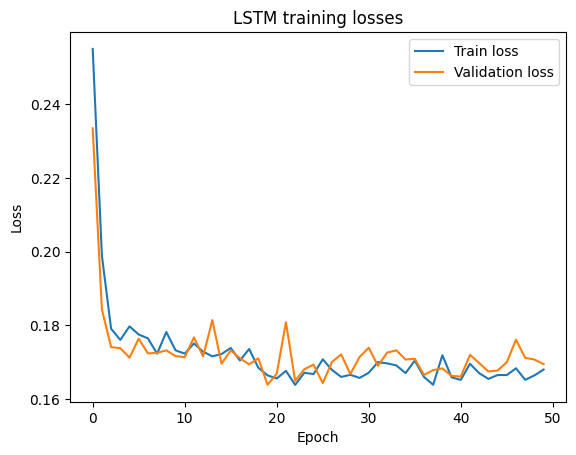

In [25]:
"""Plot training and validation losses"""
# TODO: Not sure why the training and validation quatities are not the same..
plt.title("LSTM training losses")
plt.ylabel("Loss")
plt.xlabel("Epoch")

plt.plot(total_train_losses, label="Train loss")
plt.plot(total_validation_losses, label="Validation loss")
plt.legend()
plt.show()

Evaluate Model

**NOTE**

Nothing below this line has been tested, adjustments are likely needed to work get it all working properly

In [28]:
with torch.no_grad():
    for data in dataloader_test:
        inputs = data["input_ids"]
        input_padding = 12 - inputs.size()[0], 1024 - inputs.size()[1]
        padded_inputs = nn.functional.pad(
            input=inputs,
            pad=(input_padding[1], 0, input_padding[0], 0),
            mode='constant',
            value=-1
        )
        inputs = padded_inputs.view(12, 1024, 1).type(torch.float32).to(device)  # <-- Moved to device

        labels = data["labels"]
        label_padding = 12 - labels.size()[0], 4 - labels.size()[1]
        padded_labels = nn.functional.pad(
            input=labels,
            pad=(label_padding[1], 0, label_padding[0], 0),
            mode='constant',
            value=-1
        )
        labels = padded_labels.float().view(12, -1).argmax(1).view(-1, 1).flatten().to(device)  # <-- Moved to device

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        prediction = torch.cat([prediction, predicted.cpu()], dim=0)  # move to CPU before concatenation
        truth = torch.cat([truth, labels.cpu()], dim=0)


In [29]:
"""Create performance metrics"""
accuracy = Accuracy(task="multiclass", num_classes=32)
precision = Precision(task="multiclass", average="macro", num_classes=32)
recall = Recall(task="multiclass", average="macro", num_classes=32)
f1_score = F1Score(task="multiclass", average="macro", num_classes=32)
confusion_matric = ConfusionMatrix(task="multiclass", num_classes=32)

calculated_accuracy = accuracy(truth, prediction)
calculated_precision = precision(truth, prediction)
calculated_recall = recall(truth, prediction)
calculated_f1_score = f1_score(truth, prediction)
calculated_confusion_matric = confusion_matric(truth, prediction)

print("Model Accuracy:", calculated_accuracy)
print("Model Precision:", calculated_precision)
print("Model Recall:", calculated_recall)
print("Model F1:", calculated_f1_score)

Model Accuracy: tensor(0.3810)
Model Precision: tensor(0.3711)
Model Recall: tensor(0.4250)
Model F1: tensor(0.3099)


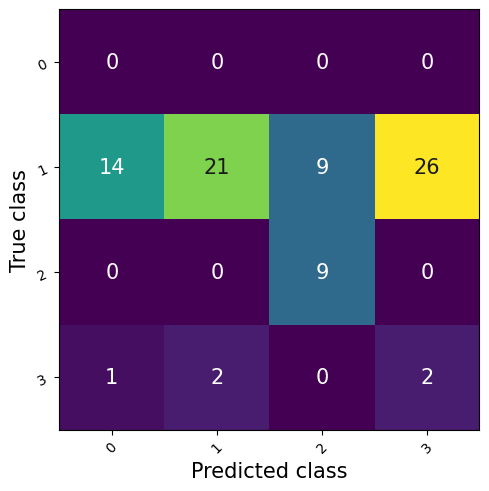

In [30]:
"""Vizulaize confusion matrix"""
metric = MulticlassConfusionMatrix(num_classes=4)
metric.update(truth, prediction)
fig_, ax_ = metric.plot()

Optimize hyperparameters

In [ ]:
#TODO: play with the parameters and optimize the CNN architecture